# Model Comparison on Complex Maze
Here I test out different models to see how many steps it takes them to reach a new terminal state after being trained towards an initial terminal state. I reuse the map 

In [8]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym

import gym_env
from utils import test_agent, get_transition_matrix, create_mapping_nb, woodbury, woodbury_SR, decision_policy_SR
from models import LinearRL, SR_TD

In [9]:
# Set the random seed for NumPy
# seed = 32
# 100 seeds
seeds = np.arange(100)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [10]:
no_goal_env = "maze-10x10-G0"
envs = ["maze-10x10-G1", "maze-10x10-G2", "maze-10x10-G3"]

In [11]:
# Model Hyperparams
reward = -0.8
alpha = 0.05
beta = 1.0
_lambda = 1.0
num_steps = 80000

# Simulation parameters
num_simulations = 20
new_term_loc = (9,1)
new_term_idx = 61

In [12]:
# Transition matrix with no goal
env = gym.make(no_goal_env)
maze = env.unwrapped.maze
# Get the transition matrix of the new environment
mapping = create_mapping_nb(env.unwrapped.maze, env.unwrapped.get_walls())
T_no_goal = get_transition_matrix(env, mapping)

### Run across multiple seeds and get averages

In [13]:
avgs = {
    'Random':{'mean':[],'median':[]},
    'SR':{'mean':[],'median':[]},
    'SR Wood':{'mean':[],'median':[]},
    'Imp Samp':{'mean':[],'median':[]},
    'Complete':{'mean':[],'median':[]}
}

# Loop through all the seeds
for seed in seeds:
    # Print seed out
    print(f"Seed: {seed}")
    
    ## Initialize and train agents
    # Initialize agents
    DR_TD_agent = LinearRL(env_name=envs[0], reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)
    Random_agent = LinearRL(env_name=envs[0], reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, num_steps=num_steps, policy="random", imp_samp=False)
    DR_Inv_agent = LinearRL(env_name=envs[0], reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)
    SR_wood_agent = SR_TD(env_name=envs[0], reward=1,  term_reward=10, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax")
    SR_agent = SR_TD(env_name=envs[0], reward=1,  term_reward=10, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax")

    # Train agents that need to be trained
    DR_TD_agent.learn(seed=int(seed))
    SR_wood_agent.learn(seed=int(seed))
    SR_agent.learn(seed=int(seed))
    T_pi = decision_policy_SR(agent=SR_wood_agent)

    ## Woodbury
    # Construct a new transition matrix and new environment
    T_new = np.copy(T_no_goal)
    T_new[new_term_idx] = 0
    T_new[new_term_idx, new_term_idx] = 1
    new_terminals = np.diag(T_new) == 1
    new_target_locs = np.array([list(new_term_loc)])
    env_new = env
    env_new.unwrapped.target_locs = [np.array((new_term_loc[0], new_term_loc[1]))]

    # Update the env of agents
    DR_Inv_agent.env = env_new
    DR_TD_agent.env = env_new
    Random_agent.env = env_new
    SR_agent.env = env_new
    SR_wood_agent.env = env_new

    # Update P
    DR_Inv_agent.P = T_new[~new_terminals][:,new_terminals]
    DR_TD_agent.P = T_new[~new_terminals][:,new_terminals]

    # Use Woodbury update to get a new DR
    DR_td = woodbury(DR_TD_agent, T_new, inv=False)
    DR_inv = woodbury(DR_Inv_agent, T_new, inv=True)
    SR_new = woodbury_SR(SR_wood_agent, T_new, T_pi, inv=False)

    # Update terminals
    DR_Inv_agent.terminals = new_terminals
    DR_TD_agent.terminals = new_terminals
    SR_wood_agent.terminals = new_terminals

    # Set the DR to updated DR for agents and update the values
    DR_TD_agent.DR = DR_td
    DR_TD_agent.update_V()
    DR_Inv_agent.DR = DR_inv
    DR_Inv_agent.update_V()
    SR_wood_agent.SR = SR_new
    SR_wood_agent.update_V()

    ## Simulate agent planning towards new goal
    # Initialize holders and run simulations
    DR_inv_avg, DR_td_avg, Random_avg, SR_td_avg, SR_wood_avg = [],[],[],[],[]
    for i in range(num_simulations):
        DR_inv_avg.append(len(test_agent(agent=DR_Inv_agent, policy=DR_Inv_agent.policy, seed=int(seed))))
        DR_td_avg.append(len(test_agent(agent=DR_TD_agent, policy=DR_TD_agent.policy, seed=int(seed))))
        Random_avg.append(len(test_agent(agent=Random_agent, policy=Random_agent.policy, seed=int(seed))))
        SR_td_avg.append(len(test_agent(agent=SR_agent, policy=SR_agent.policy, seed=int(seed))))
        SR_wood_avg.append(len(test_agent(agent=SR_wood_agent, policy=SR_wood_agent.policy, seed=int(seed))))
    
    # Append mean and median to main holder
    avgs['Complete']['mean'].append(np.mean(DR_inv_avg))
    avgs['Complete']['median'].append(np.median(DR_inv_avg))
    avgs['Imp Samp']['mean'].append(np.mean(DR_td_avg))
    avgs['Imp Samp']['median'].append(np.median(DR_td_avg))
    avgs['Random']['mean'].append(np.mean(Random_avg))
    avgs['Random']['median'].append(np.median(Random_avg))
    avgs['SR']['mean'].append(np.mean(SR_td_avg))
    avgs['SR']['median'].append(np.median(SR_td_avg))
    avgs['SR Wood']['mean'].append(np.mean(SR_wood_avg))
    avgs['SR Wood']['median'].append(np.median(SR_wood_avg))

Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Seed: 10
Seed: 11
Seed: 12
Seed: 13
Seed: 14
Seed: 15
Seed: 16
Seed: 17
Seed: 18
Seed: 19
Seed: 20
Seed: 21
Seed: 22
Seed: 23
Seed: 24
Seed: 25
Seed: 26
Seed: 27
Seed: 28
Seed: 29
Seed: 30
Seed: 31
Seed: 32
Seed: 33
Seed: 34
Seed: 35
Seed: 36
Seed: 37
Seed: 38
Seed: 39
Seed: 40
Seed: 41
Seed: 42
Seed: 43
Seed: 44
Seed: 45
Seed: 46
Seed: 47
Seed: 48
Seed: 49
Seed: 50
Seed: 51
Seed: 52
Seed: 53
Seed: 54
Seed: 55
Seed: 56
Seed: 57
Seed: 58
Seed: 59
Seed: 60
Seed: 61
Seed: 62
Seed: 63
Seed: 64
Seed: 65
Seed: 66
Seed: 67
Seed: 68
Seed: 69
Seed: 70
Seed: 71
Seed: 72
Seed: 73
Seed: 74
Seed: 75
Seed: 76
Seed: 77
Seed: 78
Seed: 79
Seed: 80
Seed: 81
Seed: 82
Seed: 83
Seed: 84
Seed: 85
Seed: 86
Seed: 87
Seed: 88
Seed: 89
Seed: 90
Seed: 91
Seed: 92
Seed: 93
Seed: 94
Seed: 95
Seed: 96
Seed: 97
Seed: 98
Seed: 99


### Plot results

/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


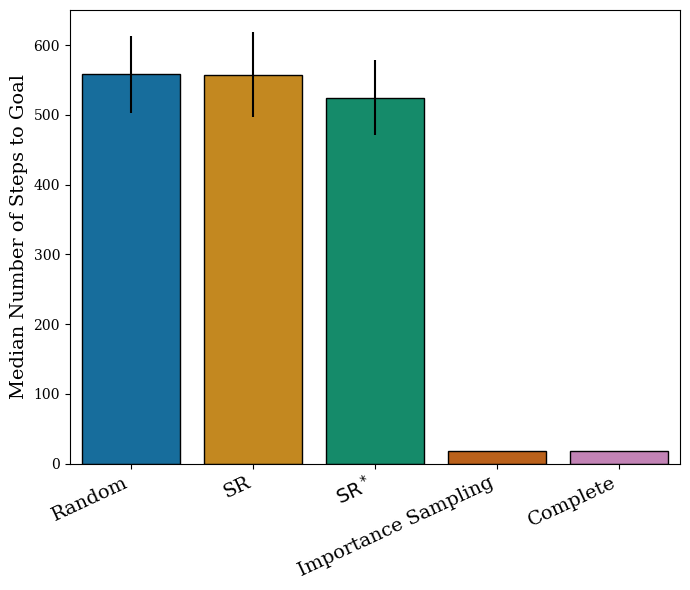

In [19]:
## Plot
# save_path = None
save_path = os.path.join('..', 'figures/') + 'model_comparison.png'
stat_type = 'median' # 'median'

x_plot = ['Random', 'SR', r'$\mathrm{SR}^*$', 'Importance Sampling', 'Complete']

# Prepare the data
categories = list(avgs.keys())
means = [np.mean(avgs[cat][stat_type]) for cat in categories]
sems = [np.std(avgs[cat][stat_type]) / np.sqrt(len(avgs[cat][stat_type])) for cat in categories]

# Create a color palette
palette = sns.color_palette("colorblind", len(categories))

# Set a nicer font
plt.rcParams['font.family'] = 'serif'

# Create the figure with adjusted size
plt.figure(figsize=(7, 6))  # Adjust these values as needed

# Create the bar plot
ax = sns.barplot(x=x_plot, y=means, palette=palette, yerr=sems, capsize=0.2)

# Set the y-axis title
plt.ylabel(f"{stat_type.capitalize()} Number of Steps to Goal", fontsize=14)

# Rotate the x-axis labels if needed
plt.xticks(rotation=25, ha='right', fontsize=14)

# Outline the bars in black
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

if save_path is not None:
    plt.savefig(save_path, bbox_inches='tight', dpi=300)

# Display the plot
plt.tight_layout()
plt.show()